**Ejercicio Práctico - Clase 3 VPC2 - 4Co2021**

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

In [2]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 409 kB 24.7 MB/s 


Se visualizan los datos del dataset CIFAR10


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


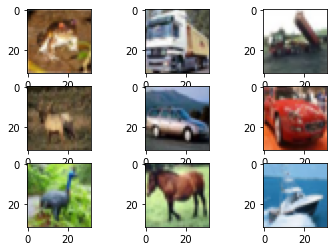

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

Transformaciones

In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=45, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)

In [15]:
#MODELO BASE
resnet18_model = torchvision.models.resnet18(pretrained=True)

resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

CONGELAR CAPAS DE LA RED BASE


In [9]:
for param in resnet18_model.parameters():
    param.requires_grad = False

In [17]:
optimizer_ft = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [19]:
result_model, history = train(resnet18_model, criterion, optimizer_ft, train_loader, valid_loader, 20)

Epoch: 1/20 - Train loss 1.571952 - Train Accuracy 0.571644 - Valid Loss 0.800524 - Valid Accuracy 0.732600
Epoch: 2/20 - Train loss 0.728223 - Train Accuracy 0.750267 - Valid Loss 0.651353 - Valid Accuracy 0.780200
Epoch: 3/20 - Train loss 0.543217 - Train Accuracy 0.812222 - Valid Loss 0.609226 - Valid Accuracy 0.793600
Epoch: 4/20 - Train loss 0.423161 - Train Accuracy 0.854044 - Valid Loss 0.585508 - Valid Accuracy 0.812600
Epoch: 5/20 - Train loss 0.321150 - Train Accuracy 0.888267 - Valid Loss 0.632372 - Valid Accuracy 0.805600
Epoch: 6/20 - Train loss 0.252235 - Train Accuracy 0.913489 - Valid Loss 0.653041 - Valid Accuracy 0.808400
Epoch: 7/20 - Train loss 0.197963 - Train Accuracy 0.932000 - Valid Loss 0.656807 - Valid Accuracy 0.815600
Epoch: 8/20 - Train loss 0.158252 - Train Accuracy 0.945178 - Valid Loss 0.732791 - Valid Accuracy 0.810600
Epoch: 9/20 - Train loss 0.132246 - Train Accuracy 0.954222 - Valid Loss 0.726331 - Valid Accuracy 0.808400
Epoch: 10/20 - Train loss 0.

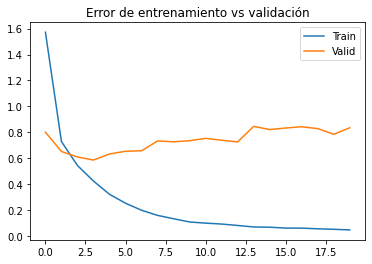

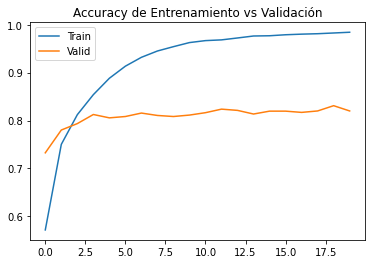

In [23]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de Entrenamiento vs Validación")
plt.legend(['Train', 'Valid'])
plt.show()

Se puede observar que si bien el accuracy arroja un resultado favorable, existe un sobreentrenamiento del modelo.


In [30]:
resnet18_model_1 = torchvision.models.resnet18(pretrained=False)

resnet18_model_1.to("cuda")

torchsummary.summary(resnet18_model_1, input_size=(3, 32, 32))
resnet18_model_1.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [31]:

optimizer_ft_2 = torch.optim.Adam(resnet18_model_1.parameters(), lr=0.0001)
criterion_2 = torch.nn.CrossEntropyLoss()

In [32]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [33]:
result_model_2, history = train(resnet18_model_1, criterion_2, optimizer_ft_2, train_loader, valid_loader, 20)


Epoch: 1/20 - Train loss 1.682234 - Train Accuracy 0.451689 - Valid Loss 1.411055 - Valid Accuracy 0.504600
Epoch: 2/20 - Train loss 1.154880 - Train Accuracy 0.586067 - Valid Loss 1.218077 - Valid Accuracy 0.567800
Epoch: 3/20 - Train loss 0.963452 - Train Accuracy 0.658200 - Valid Loss 1.113767 - Valid Accuracy 0.614200
Epoch: 4/20 - Train loss 0.791859 - Train Accuracy 0.719356 - Valid Loss 1.158709 - Valid Accuracy 0.615200
Epoch: 5/20 - Train loss 0.650145 - Train Accuracy 0.770289 - Valid Loss 1.098950 - Valid Accuracy 0.629400
Epoch: 6/20 - Train loss 0.508748 - Train Accuracy 0.821356 - Valid Loss 1.226558 - Valid Accuracy 0.625000
Epoch: 7/20 - Train loss 0.390714 - Train Accuracy 0.863178 - Valid Loss 1.339159 - Valid Accuracy 0.611600
Epoch: 8/20 - Train loss 0.305020 - Train Accuracy 0.892378 - Valid Loss 1.320303 - Valid Accuracy 0.640400
Epoch: 9/20 - Train loss 0.250391 - Train Accuracy 0.911200 - Valid Loss 1.390206 - Valid Accuracy 0.641200
Epoch: 10/20 - Train loss 0.

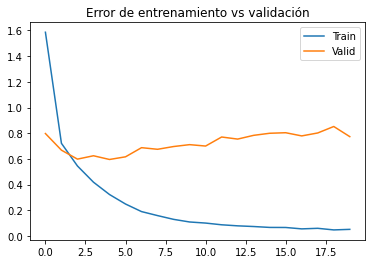

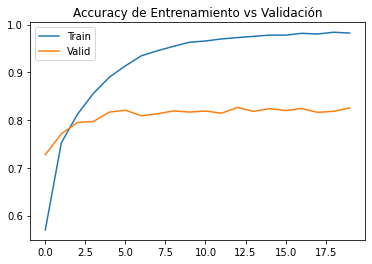

In [29]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de Entrenamiento vs Validación")
plt.legend(['Train', 'Valid'])
plt.show()

Se produjo nuevamente un sobreentrenamiento del modelo